In [34]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('/scratch/msc24h18/msc_project/aihwkit/src/')

plt.style.use('ggplot')

sys.path

['/scratch/msc24h18/.conda/envs/msc_project/lib/python311.zip',
 '/scratch/msc24h18/.conda/envs/msc_project/lib/python3.11',
 '/scratch/msc24h18/.conda/envs/msc_project/lib/python3.11/lib-dynload',
 '',
 '/home/msc24h18/.local/lib/python3.11/site-packages',
 '/scratch/msc24h18/.conda/envs/msc_project/lib/python3.11/site-packages',
 '/scratch/msc24h18/msc_project/src']

In [35]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
# FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR/pulsedAmplitudeSweep_DCIV_20240919110921/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(3)]20240919111350/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(3)]20240919111350_Summary.dat'
# FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919141831/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007_Summary.dat'
FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/_ID161ZR15000/pulsedAmplitudeSweep_DCIV_20241024112252/pulsedAmplitudeSweep_DCIV[_ID161ZR15000(1)]20241024112607/pulsedAmplitudeSweep_DCIV[_ID161ZR15000(1)]20241024112607_Summary.dat'
# FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/_ID170ZR5000/pulsedAmplitudeSweep_DCIV_20241024131813/pulsedAmplitudeSweep_DCIV[_ID170ZR5000(1)]20241024132232/pulsedAmplitudeSweep_DCIV[_ID170ZR5000(1)]20241024132232_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,1,0.148,9258059.140,1.065886e+07
1,2,2,0.196,9273340.999,1.066152e+07
2,3,3,0.244,9279622.876,1.066570e+07
3,4,4,0.292,9289622.563,1.067540e+07
4,5,5,0.340,9307000.726,1.069663e+07


Number of LTP pulses: 69
Number of LTD pulses: 73


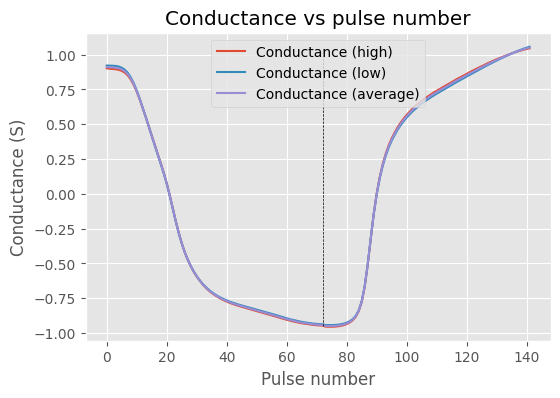

In [36]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [37]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config, params=None):
    if params is None:
        params = {'dw_min': (0.1, 0.0001, 1.0),
                  'up_down': (0.0, -0.99, 0.99),
                  'w_max': (1.0, 0.1, 2.0),
                  'w_min': (-1.0, -2.0, -0.1)
                  }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

ConstantStepDevice(
    dw_min=0.050145410065613225,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.10984707813777916,
    up_down_dtod=0.0,
    w_max=0.9125696105184637,
    w_max_dtod=0.0,
    w_min=-0.949487122203786,
    w_min_dtod=0.0
)


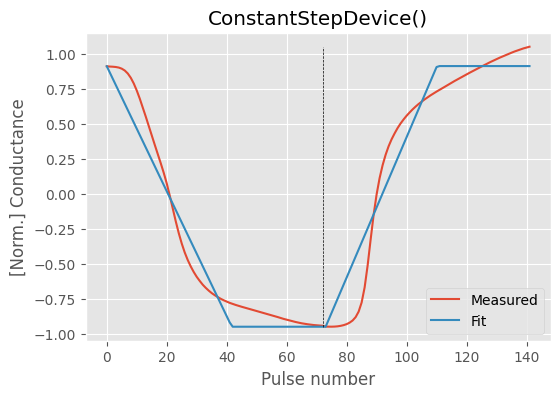

LinearStepDevice(
    dw_min=0.05014861748632368,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.10880854041823196,
    up_down_dtod=0.0,
    w_max=0.9125696587118393,
    w_max_dtod=0.0,
    w_min=-0.9495234105708568,
    w_min_dtod=0.0,
    gamma_up=1.614534453187176e-06,
    gamma_down=1.0011412370738028e-06,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0
)


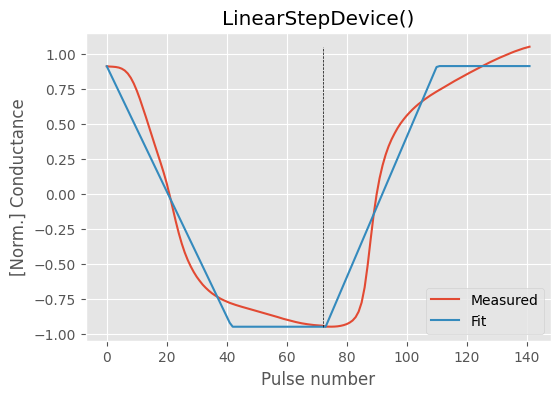

ExpStepDevice(
    dw_min=0.05174767501994987,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.12172638883630449,
    up_down_dtod=0.0,
    w_max=0.9463034292884689,
    w_max_dtod=0.0,
    w_min=-0.9778164190117811,
    w_min_dtod=0.0,
    A_up=0.0008074787373349207,
    A_down=0.8865732794546564,
    gamma_up=14.811476298874991,
    gamma_down=15.360095238605549,
    a=0.24422227257049584,
    b=0.24046456536653935
)


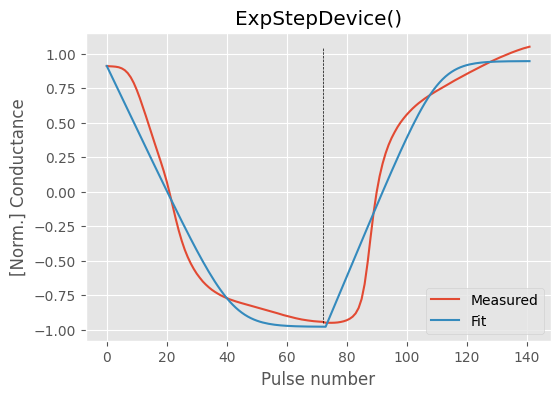

PowStepDevice(
    dw_min=0.07150247047357328,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.25726340077600995,
    up_down_dtod=0.0,
    w_max=0.9860185779519546,
    w_max_dtod=0.0,
    w_min=-1.1136596397179344,
    w_min_dtod=0.0,
    pow_gamma=0.4873391556609614,
    pow_gamma_dtod=0.0
)


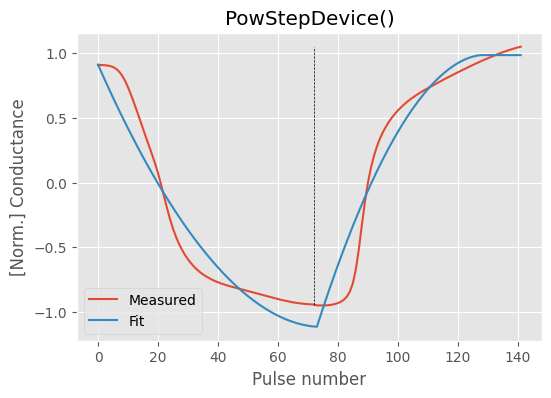

SoftBoundsDevice(
    dw_min=0.046526340103392294,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1960283840344903,
    up_down_dtod=0.0,
    w_max=1.3564849915105368,
    w_max_dtod=0.0,
    w_min=-1.6776381905593936,
    w_min_dtod=0.0
)


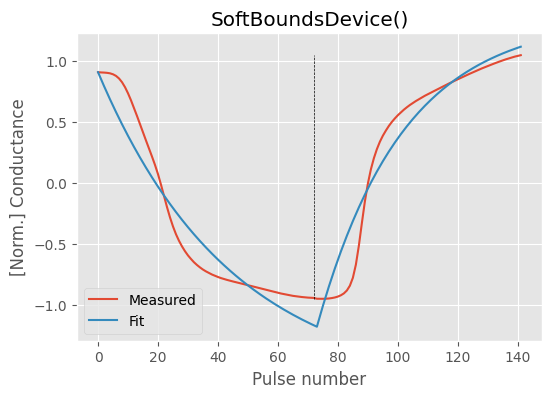

SoftBoundsPmaxDevice(
    dw_min=0.10000000000000006,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.0,
    up_down_dtod=0.0,
    w_max_dtod=0.0,
    w_min_dtod=0.0,
    p_max=58.36999744539095,
    alpha=0.0143623627825111,
    range_min=-1.3591132386531612,
    range_max=0.33818023511031015
)


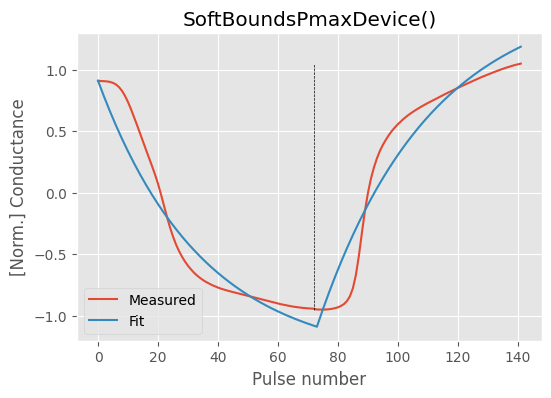

In [38]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice,
    SoftBoundsPmaxDevice
)

fit_model(ConstantStepDevice())

params = {'dw_min': (0.1, 0.0001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          'gamma_up': (0.1, 0.000001, 1.0),
          'gamma_down': (0.1, 0.000001, 1.0)
          }
fit_model(LinearStepDevice(), params)

params = {'dw_min': (0.1, 0.0001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          'gamma_up': (12.44625, 1, 20),
          'gamma_down': (12.78785, 1, 20),
          'A_up': (0.00081, 0.000001, 1),
          'A_down': (0.3683, 0.000001, 1),
          'a': (0.244, 0.001, 1.0),
          'b': (0.2425, 0.001, 1.0)
          }
fit_model(ExpStepDevice(), params)

params = {'dw_min': (0.1, 0.0001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          'pow_gamma': (1.0, 0.0001, 10),
          }
fit_model(PowStepDevice(), params)
fit_model(SoftBoundsDevice())
params = {'dw_min': (0.1, 0.0001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'range_max': (1.0, 0.1, 2.0),
          'range_min': (-1.0, -2.0, -0.1),
          'p_max': (30, 1, 200),
          'alpha': (0.0005, 0.00001, 1),
          }
fit_model(SoftBoundsPmaxDevice(), params)

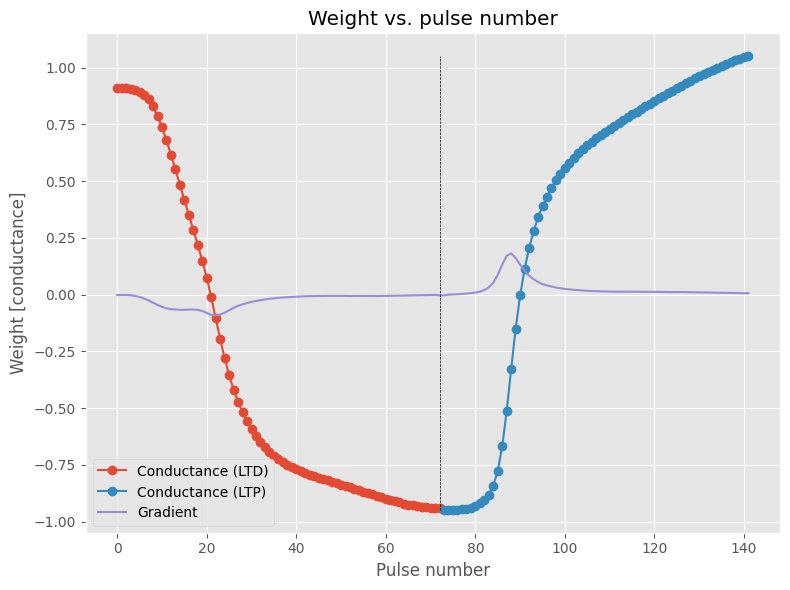

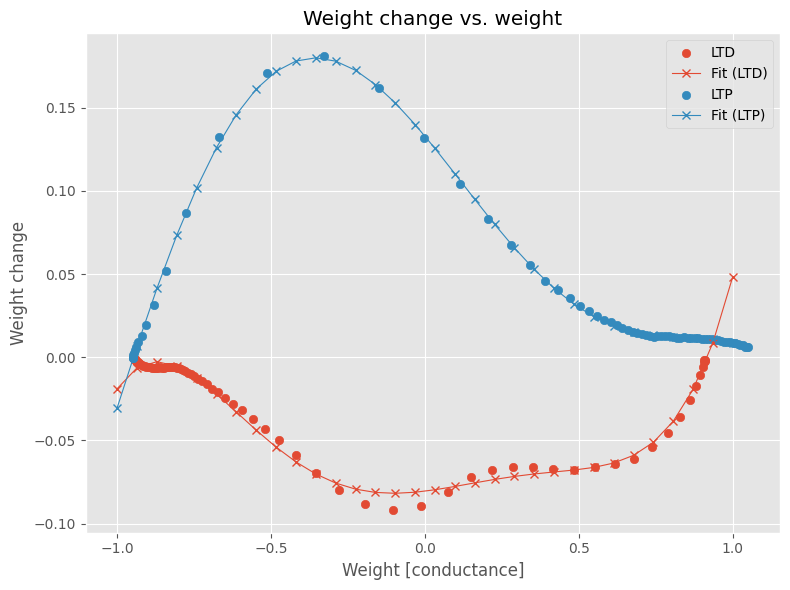

In [39]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pulses_ltd, conductance_ltd, label='Conductance (LTD)', marker='o')
ax.plot(pulses_ltp, conductance_ltp, label='Conductance (LTP)', marker='o')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Weight [conductance]", title="Weight vs. pulse number")
ax.legend()
plt.tight_layout()
# plt.savefig('tmp1.png')
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

# xvals = np.linspace(conductance.min(), conductance.max(), 100)
xvals = np.linspace(-1, 1, 32)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='C0')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='C0', lw=0.8, marker='x')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='C1')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='C1', lw=0.8, marker='x')

ax.set(xlabel="Weight [conductance]", ylabel="Weight change", title="Weight change vs. weight")
ax.legend()
plt.tight_layout()
# plt.savefig('tmp2.png')
plt.show()

PiecewiseStepDevice(
    dw_min=0.08043082544637296,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=-0.29182041072162346,
    up_down_dtod=0.0,
    w_max=1,
    w_max_dtod=0.0,
    w_min=-1,
    w_min_dtod=0.0,
    piecewise_up=[
        0.37586904109315,
        0.08153485905234369,
        0.5145553505209522,
        0.9117950008741951,
        1.2644966825238149,
        1.5663422741901287,
        1.8132513623603577,
        2.003179942746973,
        2.135919121746032,
        2.2128938178955186,
        2.236961463333682,
        2.212210705257378,
        2.143760107380407,
        2.037556851391852,
        1.9001754384144225,
        1.7386163904627885,
        1.5601049519019254,
        1.3718897909054486,
        1.1810417009139564,
        0.9942523020933671,
        0.8176327427932614,
        0.6565124010052178,
        0.5152375858211554,
        0.3969702388916727,
        0.3034866358843859,
        0.23497608794226915,
        0.1898396431419

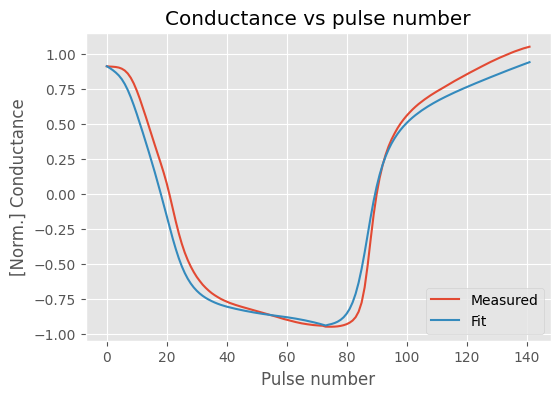

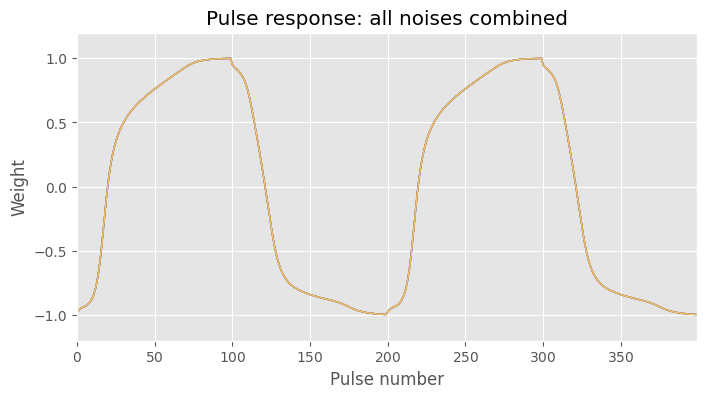

In [ ]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

# condvals = np.linspace(-1, 1, 32)
condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = np.abs(fit_grad_ltp(condvals))
fit_ltd_vals = np.abs(fit_grad_ltd(condvals))
fit_ltp_vals[-1] = 0
fit_ltd_vals[0] = 0

# get granularity near 0
granularity_up = np.abs(fit_grad_ltp(0))
granularity_down = np.abs(fit_grad_ltd(0))
min_granularity = min(granularity_up, granularity_down)

dw_min = min_granularity
fit_ltp_vals /= dw_min
fit_ltd_vals /= dw_min

params = {'dw_min': dw_min,
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=list(fit_ltp_vals),
        piecewise_down=list(fit_ltd_vals)
    ))


# pw_device_fit.dw_min = 0.01
# pw_device_fit.piecewise_up = [1, 1, 1]
# pw_device_fit.piecewise_down = [1, 1, 1]

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

pw_device_fit.dw_min_dtod = 0  # 0.3
pw_device_fit.dw_min_std = 0  # 0.3
pw_device_fit.w_min_dtod = 0  # 0.3
pw_device_fit.w_max_dtod = 0  # 0.3
pw_device_fit.write_noise_std = 0  # 0.3
pw_device_fit.up_down_dtod = 0

rpu_config = build_config('sgd', pw_device_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax = plot_device_compact(pw_device_fit, n_steps=100, n_traces=5, n_loops=2, axes=ax)
ax.set(xlabel="Pulse number", ylabel="Weight", title="Pulse response: all noises combined")

plt.savefig('tmp.png')
plt.show()

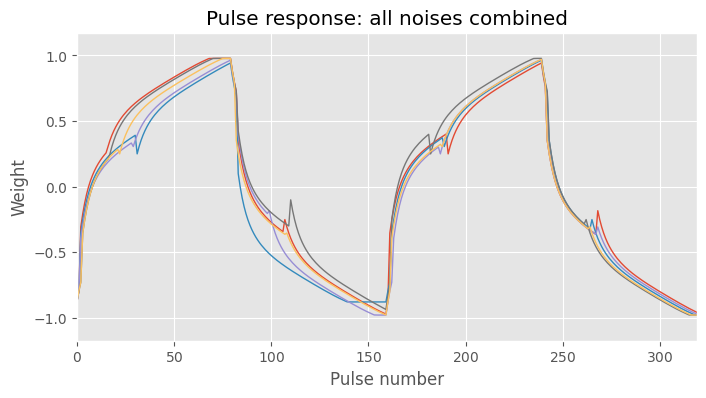

In [46]:
from aihwkit.simulator.configs.compounds import OneSidedUnitCell

pw_device_fit.dw_min_dtod = 0  # 0.3
pw_device_fit.dw_min_std = 0  # 0.3
pw_device_fit.w_min_dtod = 0  # 0.3
pw_device_fit.w_max_dtod = 0  # 0.3
pw_device_fit.write_noise_std = 0  # 0.3
pw_device_fit.up_down_dtod = 0

rpu_config = build_config('sgd', pw_device_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax = plot_device_compact(OneSidedUnitCell([pw_device_fit], refresh_every=1), n_steps=80, n_traces=5, n_loops=2, axes=ax)
ax.set(xlabel="Pulse number", ylabel="Weight", title="Pulse response: all noises combined")

plt.savefig('tmp.png')
plt.show()

(<Axes: >, -0.01022326946258545)

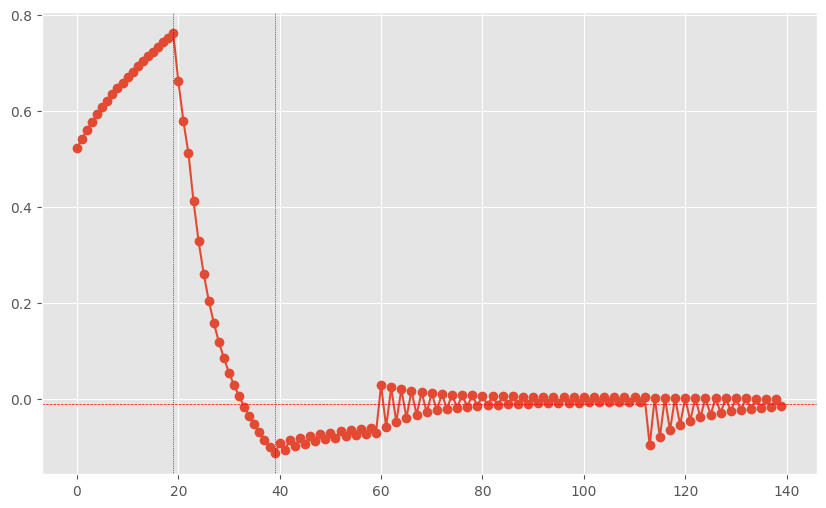

In [47]:
import msc_project.utils.asymmetric_pulsing as ap

ap.plot_symmetry_point(device=OneSidedUnitCell([pw_device_fit], refresh_every=1),
                       algorithm='sgd', marker='o', w_init=0.5, n_steps=20, alternating_pulses=100)